In [ ]:
import seaborn as sns

from data import Data
import matplotlib.pyplot as plt                                                             
import scipy.cluster.hierarchy as sch
from feature_importance import FeatureImportance
from dimension_reduction import display_umap_2d_plot, display_tsne_2d_plot, PCADimensionReduction
from kmeans_clustering import KMeansClustering
from heatmap import Heatmap

In [ ]:
data_filepath = "data/SC_integration/counts_ctc_simulated_123_5k.tsv"
true_results_filepath = "data/SC_integration/ids_ctc_simulated_123_5k.tsv"
train_indices_filepath = "data/SC_integration/train_indices.npy"
test_indices_filepath = "data/SC_integration/test_indices.npy"
SEED = 42

data_object = Data(data_filepath, true_results_filepath)
train_data, test_data, train_true_results, test_true_results =  data_object.load_train_test_split(train_indices_filepath, test_indices_filepath)
scaled_train_data, scaled_test_data = data_object.get_scaled_train_test_data()

## Najważniejsze zmienne

In [ ]:
converted_train_data, converted_test_data, converted_train_true_results, converted_test_true_results = data_object.get_converted_train_test_split()
columns = train_data.columns.values.tolist()
feature_importance_object = FeatureImportance(converted_train_data, converted_test_data, converted_train_true_results, converted_test_true_results, columns)
feature_importance_object.logistic_regression_coefficients_importance()

Widzimy, że tylko niewielka część genów będzie służyła do określenia, czy dany materiał generyczny należy do komórki raka. Poza tym na wykresie widać, że jest więcej genów śwadczących o obecności raka, niż genów, które mogłyby służyć do predykcji jego nieobecności.

## PCA

PCA - principal component analysis is about creating lines in multidimensional space, that take into account which variable differ the samples the most. PCA lines (called PC) also correspond to some percentage of total data variation and coefficients of these lines to concrete variables. The bar plot that shows this variation percentage is called scree plot.

Below we see scree plots for some amount of PC lines. The first line (PC1) for unscaled data has about 14% of total variation, which seems to be a little. We see that only a few PCA lines have significant percentage of total variation for unscaled data.

In case of scaled data PC1 is responsible for about 3% of total variation and the variation is more spread out across all lines.

In [ ]:
pca_object = PCADimensionReduction(train_data, scaled_train_data, train_true_results, SEED)
components_amounts_list = [2000, 100, 50, 20, 10]
pca_object.generate_scree_plots(components_amounts_list)

Here we take only 2 PCs, which are responsible for about 17% of total variation, which is not much and the plot should be considered as noisy. We see that there are 3 large groups of cells and the CTC cells let's say outliers of these groups. Moreover, CTC cells differ mostly in PC1.

Additionally, in case of scaled data we can see that CTC cells are better separated than with unscaled data, which is very interested.

In [ ]:
pca_object.display_pc1_pc2_plot()

Here we have the biggest loading scores for PC1 - they are coefficients of unit vector of the PC1 line, so in some way coefficient of PC1. Variables with the biggest loading scores should differ samples the most.

In [ ]:
top_variables = pca_object.get_most_important_variables_from_pc1(10)
top_variables

## UMAP

In [ ]:
display_umap_2d_plot(scaled_train_data, train_true_results, SEED)

## TSNE

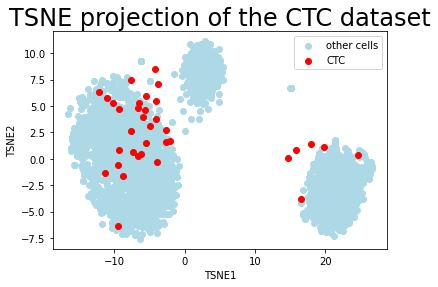

In [3]:
display_tsne_2d_plot(train_data, train_true_results, SEED)

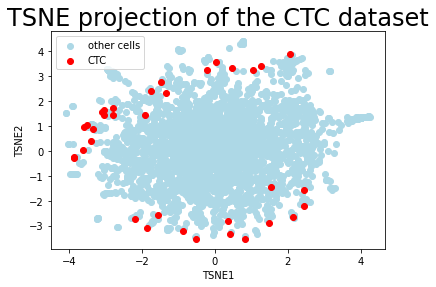

In [5]:
display_tsne_2d_plot(scaled_train_data, train_true_results, SEED)

## K-means CLustering

Here we have plots that show how good is clustering of CTC subset. Our goal is to have all CTC cells in one cluster. Firstly we checked raw data, then data of first 20 PCs and first 20 genes of PC1. In general clustering is not so good - at most 70-80% of CTC were gathered to 1 cluster. In addition, in CTC subset there were distinguished at most about 10 different clusters.

In [ ]:
k_array = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
k_means_object = KMeansClustering(train_true_results, SEED)
k_means_object.k_means_clustering_for_different_k(scaled_train_data, k_array)

In [ ]:
k_means_object.k_means_clustering_for_different_k(scaled_train_data, k_array, pca=20)

In [ ]:
pc1_top_variables = pca_object.get_most_important_variables_from_pc1(20)
k_means_object.k_means_clustering_for_different_k(scaled_train_data[pc1_top_variables.index], k_array)

Here we have 2D PCA clustering. The dots with red edges are CTC cells. We can see that some of CTC cells are different from other cells and they have separate clusters, but there are also some CTC cells, that are similar to rest of the cells.

In [ ]:
k_means_object.display_2d_pca_clustering(scaled_train_data, [2,3,4,5,6])

## Dendrogram

diagram w kształcie drzewa ukazujący związki pomiędzy wybranymi elementami na podstawie przyjętego kryterium.
Dendrogram można wykorzystać do określenia liczby klastrów na które można podzielić dane.


Dostępne kryteria przy łączeniu klastrów:
'ward'     - minimalizuje wariancję łączonych klastrów;
'average'  - maksymalizuje średni dystans pomiędzy punktami w różnych klastrach;
'complete' - minimalizuje maksymalną odległość między punktami w klastrach;
'single'   - maksymalizuje najmniejszą odległość między punktami w klastrach;

Paramatr p - ilość klastrów



In [ ]:
def rysuj(data, linkage_method, p):
    
    plt.figure(figsize=(15,8))
    dendro = sch.dendrogram(sch.linkage(data, method=linkage_method), truncate_mode='lastp', p=p)
    plt.ylabel(f'kryterium łączenia klastrów ({linkage_method})',fontsize=15)
    plt.title(f'dendrogram dla kryterium: {linkage_method}',fontsize=15)
    plt.show

In [ ]:
# dla surowych danych
rysuj(train_data, 'ward', 50)

In [ ]:
# dla przeskalowanych danych
rysuj(scaled_train_data, 'ward', 50)

## Heatmap

In [ ]:
import numpy as np

# heatmap_object = Heatmap(train_data)
# heatmap_object.heatmap()

matrix = train_data.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0)
plt.show()
sns.clustermap(train_data, annot=True, center=0)
plt.show()